# RAQ - comparing Open and Closed-source models

### Import Libraries

In [6]:
import os
import csv
from time import sleep
import pandas as pd
import utils

from dotenv import load_dotenv
from datasets import load_dataset
from generator import Generator

load_dotenv('env/var.env')

CSV_FILE = "assets/model_answers.csv"
RAQ = "assets/RAQ.csv"
RAQ_RESULTS = "assets/RAQ_results.csv"

## Define models

### Open models

In [2]:
llama2_70b = Generator(model='meta/llama2-70b', api_key=os.getenv("NGC_API_KEY"))

yi = Generator(model='01-ai/yi-large', api_key=os.getenv("NGC_API_KEY"))

dbrx = Generator(model='databricks/dbrx-instruct', api_key=os.getenv("NGC_API_KEY"))

gemma_7b = Generator(model='google/gemma-7b', api_key=os.getenv("NGC_API_KEY"))

mistral7b = Generator(model="mistralai/mistral-7b-instruct-v0.3", api_key=os.getenv("NGC_API_KEY"))

mixtral8x7b = Generator(model='mistralai/mixtral-8x7b-instruct-v0.1', api_key=os.getenv("NGC_API_KEY"))

mixtral8x22b = Generator(model='mistralai/mixtral-8x22b-instruct-v0.1', api_key=os.getenv("NGC_API_KEY"))

llama3_70b = Generator(model='meta/llama3-70b-instruct', api_key=os.getenv("NGC_API_KEY"))

llama3_1_70b = Generator(model='meta/llama-3.1-70b-instruct', api_key=os.getenv("NGC_API_KEY"))

llama3_1_405b = Generator(model='meta/llama-3.1-405b-instruct', api_key=os.getenv("NGC_API_KEY"))

### Closed-source models

In [3]:
gpt_3_5_turbo = Generator(model="gpt-3.5-turbo", api_key=os.getenv("OPENAI_KEY"))

gpt_4_turbo = Generator(model="gpt-4-turbo", api_key=os.getenv("OPENAI_KEY"))

claude_3_5_sonnet = Generator(model="claude-3-5-sonnet-20240620", api_key=os.getenv("ANTHROPIC_KEY"))

claude_3_oppus = Generator(model="claude-3-opus-20240229", api_key=os.getenv("ANTHROPIC_KEY"))

gemini_1_5_flash = Generator(model="gemini-1.5-flash-001", api_key=os.getenv("GEMINI_KEY"))

gemini_1_0_pro = Generator(model="gemini-1.0-pro", api_key=os.getenv("GEMINI_KEY"))

### Define the names of the models

In [ ]:
models = {
    "llama2_70b": llama2_70b,
    "yi": yi,
    "dbrx": dbrx,
    "gemma_7b": gemma_7b,
    "mistral7b": mistral7b, 
    "mixtral8x7b": mixtral8x7b, 
    "mixtral8x22b": mixtral8x22b,
    "llama3_70b": llama3_70b,
    "llama3_1_70b": llama3_1_70b,
    "llama3_1_405b": llama3_1_405b,
    "gpt_3_5_turbo": gpt_3_5_turbo,
    "gpt_4_turbo": gpt_4_turbo,
    "claude_3_5_sonnet": claude_3_5_sonnet,
    "claude_3_oppus": claude_3_oppus,
    "gemini_1_5_flash": gemini_1_5_flash,
    "gemini_1_0_pro": gemini_1_0_pro
}

### Load Q&A Data 

In [5]:
squad = load_dataset("squad", split="train")
squad = squad.shuffle()

### Create dictionary to save metrics

In [3]:
metrics = {}

for model in models.keys():
    metrics[f"{model}_metrics"] = {
        "rank": [],
    }

### Create CSV file to save the answers

In [7]:
headers = list(models.keys()) + ['correct_answer']

with open(CSV_FILE, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=headers)
    writer.writeheader()

### Gather answers from the models

In [ ]:
for i in range(320):
    context = squad[i]['context']
    query = squad[i]['question']
    answer = squad[i]['answers']['text'][0]

    llm_answers_dict = {"correct_answer": answer}
    
    for model in models.keys():
        try:
            llm_response = utils.get_llm_response(models[model], context, query)
        except:
            llm_response = " "
        llm_answers_dict[model] = llm_response
        
        # Timeout for the gemini 1.5 model
        if i % 15 == 0:
            sleep(30)
        
    with open(CSV_FILE, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        writer.writerow(llm_answers_dict)

### Rank the models based on the answers

In [4]:
df = pd.read_csv(CSV_FILE)

for index, row in df.iterrows():
    csv_dict = row.to_dict()
    answer = csv_dict.pop("correct_answer")
    
    rank = utils.get_gpt_rank(answer, csv_dict, os.getenv("OPENAI_KEY"))

    for idx, model in enumerate(models.keys()):
        rank_value = rank[model]
        metrics[f"{model}_metrics"]["rank"].append(rank_value)

### Metrics aggregation

In [3]:
df = pd.DataFrame({key.replace('_metrics', ''): value['rank'] for key, value in metrics.items()})
df = df.mean().reset_index()
df.columns = ['Model', 'RAQ']

data = pd.read_csv(RAQ)

RAQ_results = data.merge(df, on='Model', how='left')
RAQ_results.to_csv(RAQ_RESULTS, index=False)

In [7]:
df_results = pd.read_csv(RAQ_RESULTS, parse_dates=["Date"])

### Graph analysis

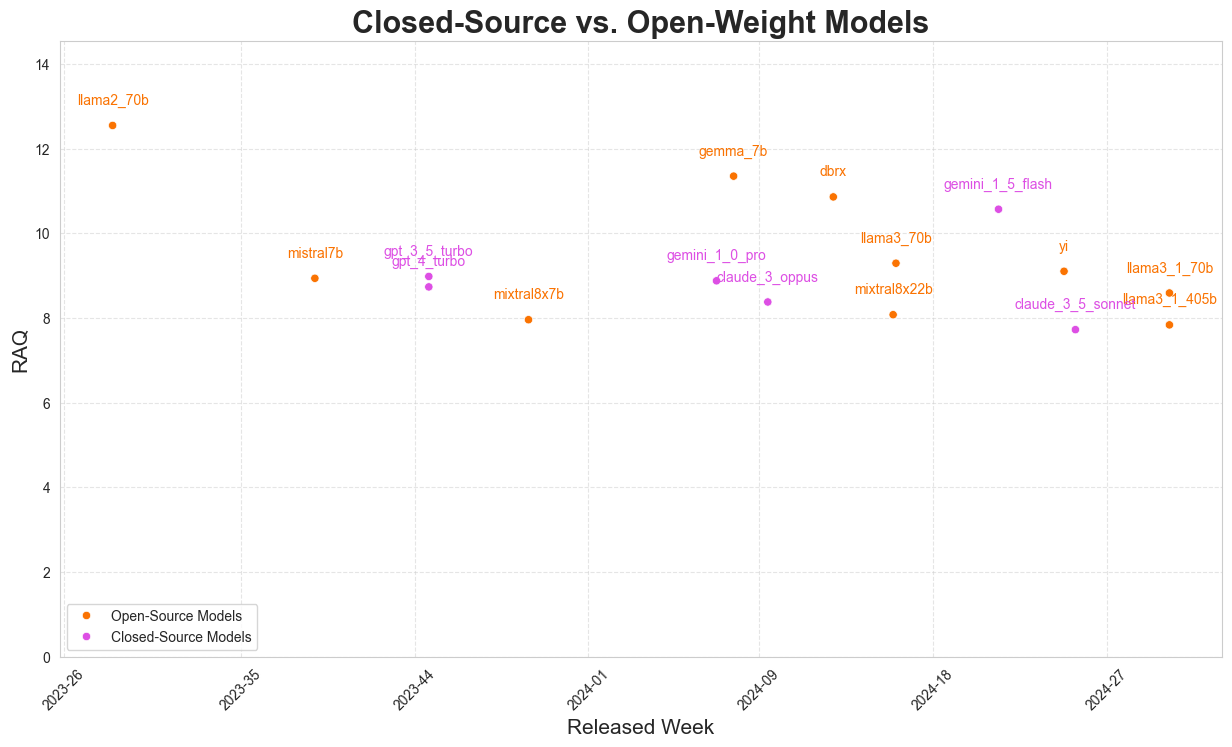

In [3]:
utils.scatterplot(df_results)

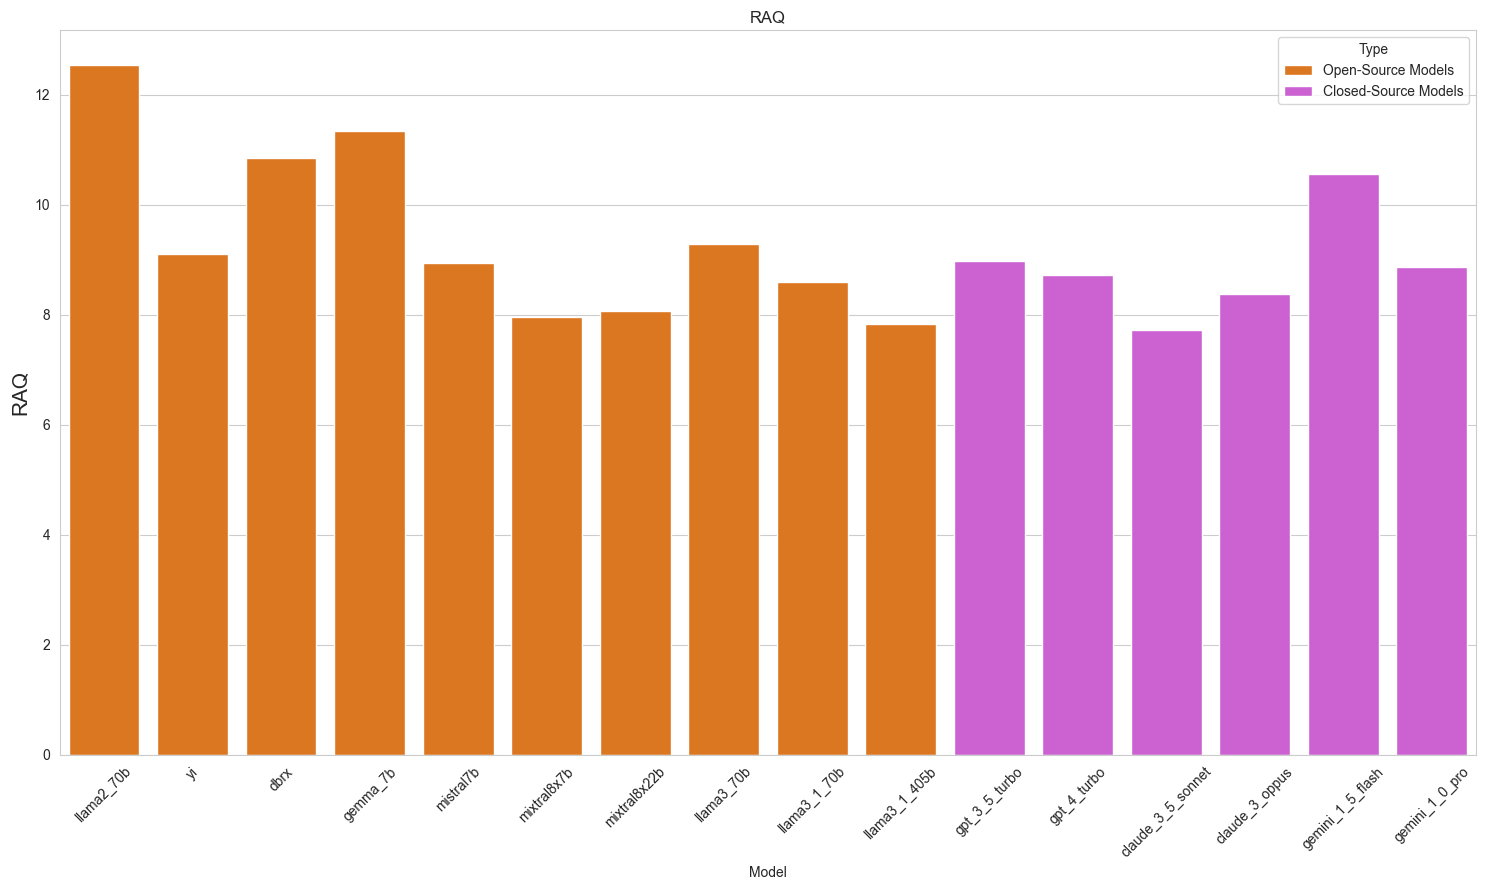

In [4]:
utils.barplot(df_results)